<a href="https://colab.research.google.com/github/bhushanmandava/Time-Series/blob/main/Arima%2CSarima%2CSarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima==2.0.4 -q
!pip uninstall -y numpy
!pip install --no-cache-dir --force-reinstall numpy==1.26.4

import os
os._exit(00)

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 225.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import ParameterGrid
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA  # if you need to manually build ARIMA models
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error,root_mean_squared_error
# from statsmodels.tools.eval_measures import rmse

In [4]:
df = pd.read_csv("daily_revenue.csv" , index_col='date',parse_dates=True,dayfirst=True)
df.head(20)

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%
2018-01-06,"6,095,418",25.02%,0.87%
2018-01-07,"7,661,844",25.33%,1.06%
2018-01-08,"7,036,112",24.83%,1.03%
2018-01-09,"7,100,900",25.11%,1.00%


In [6]:
df['revenue']=df['revenue'].str.replace(',','').astype(float)

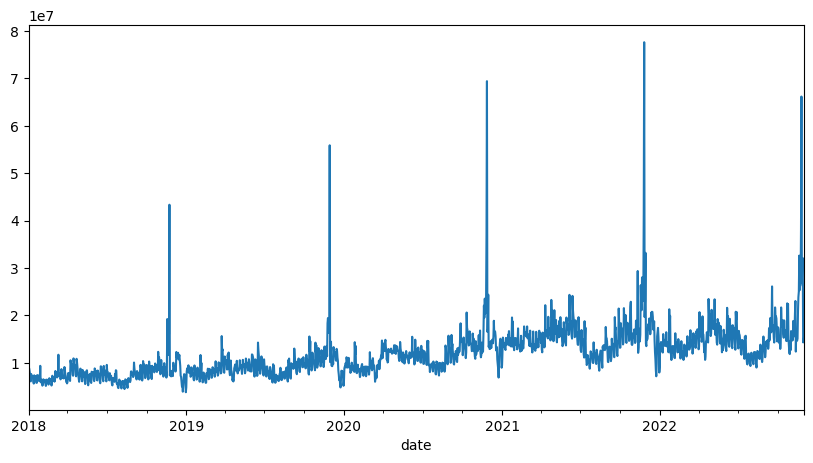

In [7]:
df["revenue"].plot(figsize=(10,5) )
plt.show()

In [8]:
#setting up frequency as dialy
df_revenue = df.asfreq('D')

<ipython-input-12-8a24b3699276>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_plot(df['revenue'].resample('M').mean())


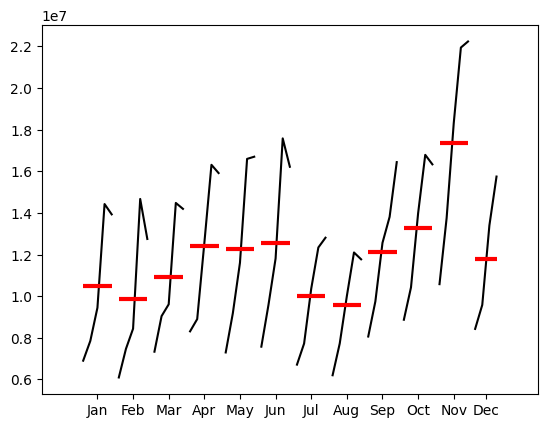

In [12]:
month_plot(df['revenue'].resample('M').mean())
plt.show()

<ipython-input-13-39a5a1dc5e3b>:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(df['revenue'].resample('Q').mean())


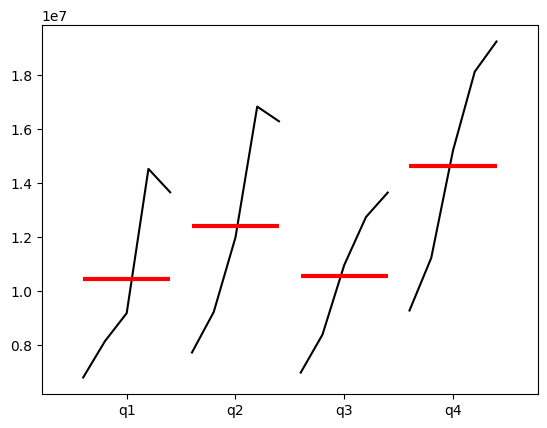

In [13]:
quarter_plot(df['revenue'].resample('Q').mean())
plt.show()

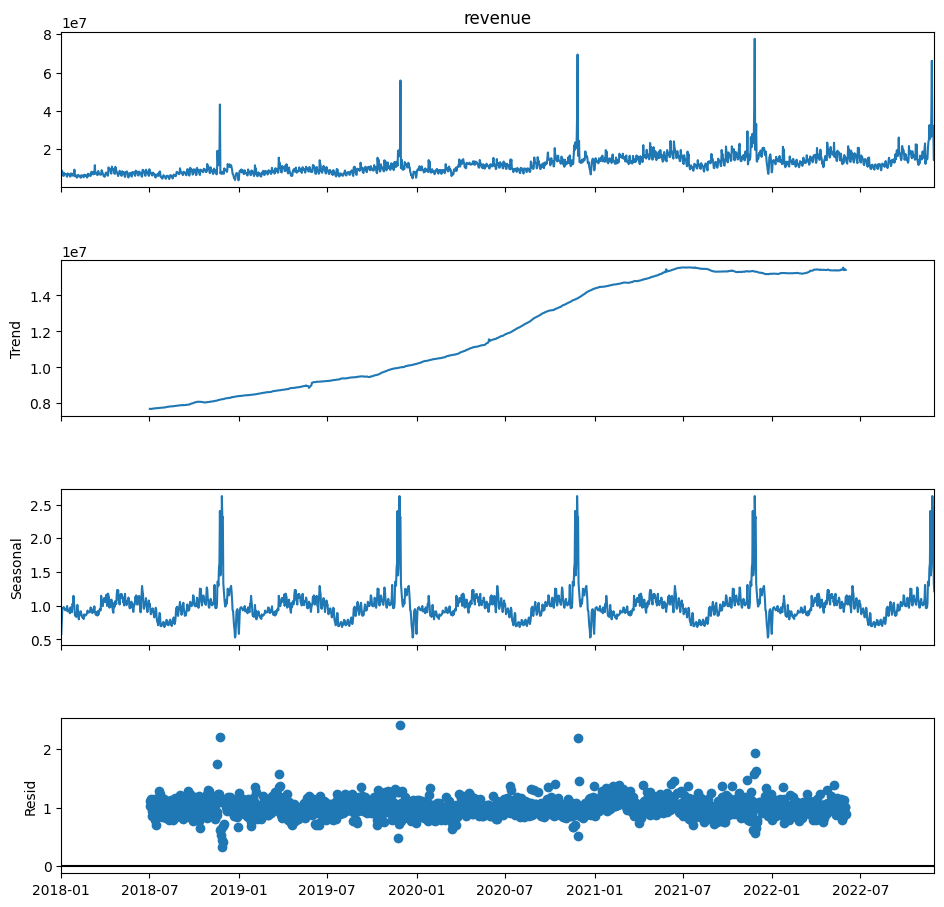

In [15]:
decomposition=seasonal_decompose(df['revenue'],model="mul",period=365)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

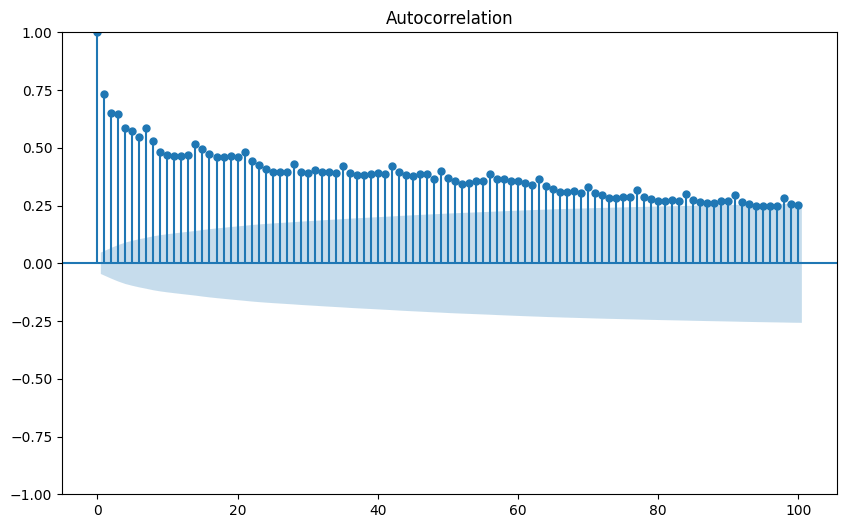

In [17]:
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['revenue'], lags = 100, ax = ax)
plt.show()

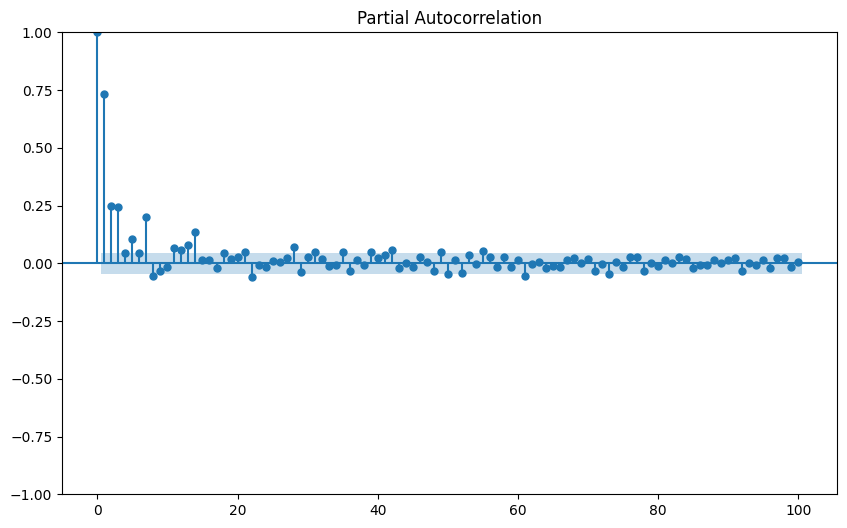

In [19]:
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['revenue'], lags = 100, ax = ax)
plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.revenue)
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")


p-value: 0.101904
Evidence suggests that the time series is not stationary.


In [21]:
df['revenue_diff'] = df.revenue.diff().dropna()
df['revenue_diff']

,revenue_diff
date,
2018-01-01,NaN
2018-01-02,2651237.0
2018-01-03,-475975.0
2018-01-04,-660303.0
2018-01-05,-1410495.0
...,...
2022-11-26,-39180777.0
2022-11-27,4955921.0
2022-11-28,210050.0


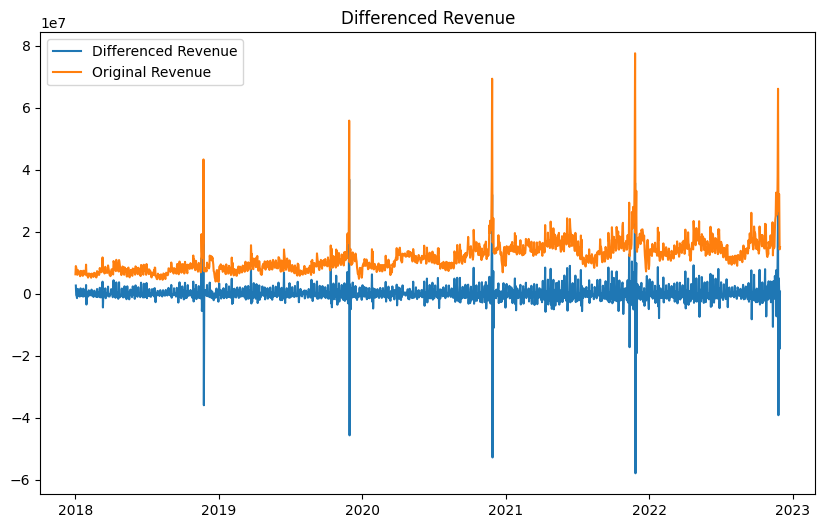

In [24]:
plt.figure(figsize=(10,6))
# plt.subplot(2,1,2)
plt.plot(df['revenue_diff'],label='Differenced Revenue')
plt.legend()
plt.title('Differenced Revenue')


plt.plot(df['revenue'],label='Original Revenue')
plt.legend()
plt.show()

In [28]:
period=30
train,test =df.iloc[:-period],df.iloc[-period:]
test.head()

,revenue,discount_rate,coupon_rate,revenue_diff
date,,,,
2022-11-01,16703680.0,23.85%,1.50%,4014654.0
2022-11-02,15827022.0,20.76%,0.94%,-876658.0
2022-11-03,16154319.0,21.85%,0.92%,327297.0
2022-11-04,14707212.0,20.17%,0.88%,-1447107.0
2022-11-05,14877530.0,17.85%,0.41%,170318.0


In [29]:
model = auto_arima(train['revenue'],seasonal=False)
model.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28817.267
Date:                Wed, 23 Apr 2025   AIC                          57650.535
Time:                        18:07:20   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.000       0.103       0.211
ar.L4          0.0679      0.029      2.365      0.018       0.012       0.124
ar.L5          0.0466      0.024      1.937      0.053      -0.001       0.094
ma.L1         -0.1598      0.118     -1.354      0.176      -0.391       0.071
ma.L2         -0.7423      0.108     -6.872      0.000      -0.954      -0.531
sigma2      9.084e+12   1.86e-14   4.88e+26      0.000    9.08e+12    9.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            580903.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             5.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+42. Standard errors may be unstable.
"""

In [30]:
predictions_arima = model.predict(n_periods = len(test))
predictions_arima

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0
2022-11-01,1.445299e+07
2022-11-02,1.474103e+07
2022-11-03,1.503283e+07
2022-11-04,1.527520e+07
2022-11-05,1.534078e+07
2022-11-06,1.553442e+07
2022-11-07,1.554542e+07
2022-11-08,1.563967e+07
2022-11-09,1.565016e+07
2022-11-10,1.569221e+07


In [31]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = root_mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

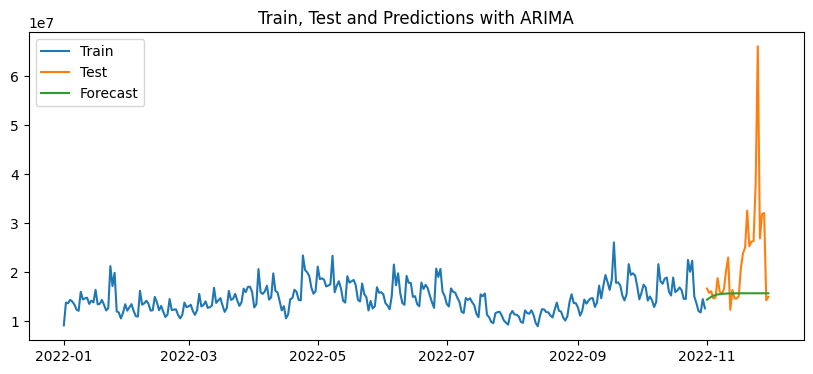

The MAE is 7267306.02
The RMSE is 12366038.29
The MAPE is 24.15 %


In [37]:
model_assessment(train['revenue']['2022':], test['revenue'], predictions_arima, "ARIMA")

In [38]:
#Sarima
model = auto_arima(train['revenue'],seasonal=True,m=7)
model.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28762.051
Date:                           Wed, 23 Apr 2025   AIC                          57546.103
Time:                                   18:15:51   BIC                          57606.331
Sample:                               01-01-2018   HQIC                         57568.358
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.007e+04   4683.063      2.150      0.032     889.683    1.92e+04
ar.L1         -0.3476      0.072     -4.798      0.000      -0.490      -0.206
ar.L2          0.1856      0.032      5.722      0.000       0.122       0.249
ar.L3          0.1034      0.016      6.523      0.000       0.072       0.135
ma.L1         -0.1958      0.074     -2.656      0.008      -0.340      -0.051
ma.L2         -0.5684      0.060     -9.401      0.000      -0.687      -0.450
ar.S.L7        0.0805      0.181      0.445      0.656      -0.274       0.435
ar.S.L14       0.8712      0.172      5.071      0.000       0.534       1.208
ma.S.L7       -0.0035      0.176     -0.020      0.984      -0.349       0.342
ma.S.L14      -0.8322      0.157     -5.310      0.000      -1.139      -0.525
sigma2      9.294e+12      0.000   8.85e+16      0.000    9.29e+12    9.29e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            848628.48
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             5.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+31. Standard errors may be unstable.
"""

In [40]:
predictions_sarima = model.predict(n_periods = len(test))
predictions_sarima

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0
2022-11-01,1.513413e+07
2022-11-02,1.504531e+07
2022-11-03,1.464456e+07
2022-11-04,1.382187e+07
2022-11-05,1.398001e+07
2022-11-06,1.697840e+07
2022-11-07,1.583295e+07
2022-11-08,1.605198e+07
2022-11-09,1.575788e+07
2022-11-10,1.523578e+07


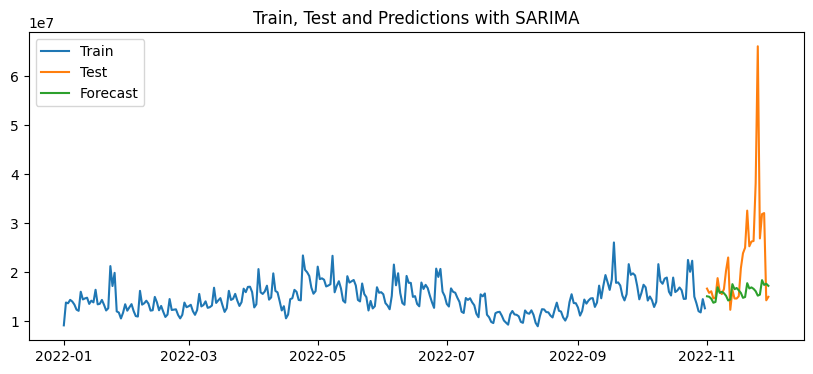

The MAE is 7210576.21
The RMSE is 12152429.39
The MAPE is 24.54 %


In [42]:

model_assessment(train['revenue']['2022':], test['revenue'], predictions_sarima, "SARIMA")

In [43]:
df['discount_rate'] = df['discount_rate'].str.replace("%", "").astype(float)
df['coupon_rate'] = df['coupon_rate'].str.replace("%", "").astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        1795 non-null   float64
 1   discount_rate  1795 non-null   float64
 2   coupon_rate    1795 non-null   float64
 3   revenue_diff   1794 non-null   float64
dtypes: float64(4)
memory usage: 70.1 KB


In [44]:
test_days = 30 # Number of days to reserve for testing
exog_train, exog_test = df.iloc[:-test_days,1:3], df.iloc[-test_days:,1:3]
exog_test.head()

,discount_rate,coupon_rate
date,,
2022-11-01,23.85,1.50
2022-11-02,20.76,0.94
2022-11-03,21.85,0.92
2022-11-04,20.17,0.88
2022-11-05,17.85,0.41


In [46]:
model_sarimax = auto_arima(train['revenue'],
                           m = 7,
                           X = exog_train)
model_sarimax.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28613.022
Date:                           Wed, 23 Apr 2025   AIC                          57250.045
Time:                                   18:23:13   BIC                          57315.749
Sample:                               01-01-2018   HQIC                         57274.324
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.641e+04   7880.847      2.082      0.037     964.544    3.19e+04
discount_rate   4.03e+05   2.35e+04     17.146      0.000    3.57e+05    4.49e+05
coupon_rate    9.229e+05   6.09e+04     15.156      0.000    8.04e+05    1.04e+06
ar.L1            -0.6527      0.155     -4.198      0.000      -0.957      -0.348
ar.L2             0.1827      0.049      3.766      0.000       0.088       0.278
ma.L1             0.1067      0.155      0.690      0.490      -0.197       0.410
ma.L2            -0.6922      0.124     -5.567      0.000      -0.936      -0.449
ar.S.L7           0.0524      0.187      0.280      0.780      -0.315       0.419
ar.S.L14          0.8999      0.178      5.062      0.000       0.551       1.248
ma.S.L7           0.0182      0.183      0.099      0.921      -0.340       0.376
ma.S.L14         -0.8501      0.161     -5.286      0.000      -1.165      -0.535
sigma2         7.655e+12      0.016   4.82e+14      0.000    7.65e+12    7.65e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1075250.80
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       123.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.85e+29. Standard errors may be unstable.
"""

In [48]:
predictions_sarimax = model_sarimax.predict(n_periods = len(test),
                                            X = exog_test)
predictions_sarimax

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0
2022-11-01,1.675203e+07
2022-11-02,1.494534e+07
2022-11-03,1.488390e+07
2022-11-04,1.296350e+07
2022-11-05,1.205396e+07
2022-11-06,1.394979e+07
2022-11-07,1.341718e+07
2022-11-08,1.328240e+07
2022-11-09,1.441167e+07
2022-11-10,2.077564e+07


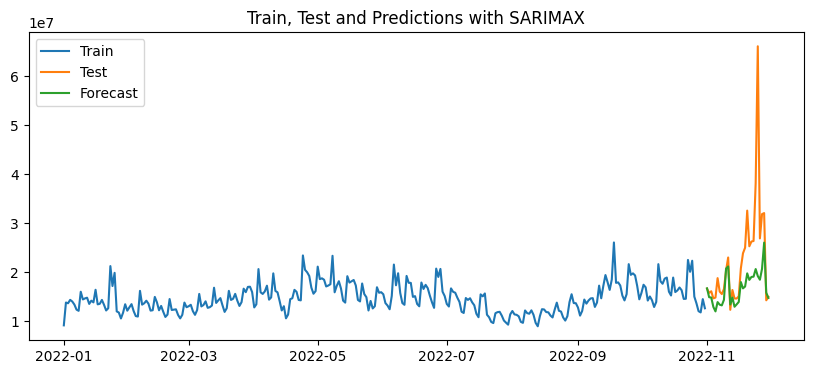

The MAE is 5716506.24
The RMSE is 10394553.04
The MAPE is 19.36 %


In [49]:
model_assessment(train['revenue']['2022':], test['revenue'], predictions_sarimax, "SARIMAX")

In [50]:
model_cv = ARIMA(order = (2, 1, 2), seasonal_order = (2, 0, 2, 7))

In [59]:
from pmdarima.model_selection import RollingForecastCV,cross_val_score


In [57]:
cv = RollingForecastCV(h = 30, # forecast horizon
                                       step = 15, # moves the validation window by n time steps each iteration
                                       initial = df.shape[0] - 180) # starting point for the first training set

In [61]:
cv_score = cross_val_score(model_cv,
                                           y=df['revenue'],  # Target variable 'y'
                                           X=df.iloc[:, 1:3],  # Explanatory variables from columns 1 and 2
                                           scoring='mean_squared_error',  # Evaluation metric: Mean Squared Error
                                           cv=cv,  # Cross-validation strategy
                                           verbose=1,  # Verbosity level
                                           error_score=10000000000000000000000  # Value to assign if fitting error occurs
                                           )

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati

In [62]:
rmse = np.sqrt(np.average(cv_score))
print(f"The RMSE is {int(rmse)}")

The RMSE is 4405840


In [63]:
param_grid = {'p': [1],
              'd': [0,1],
              'q': [1,2],
              'P': [1,2],
              'D': [0],
              'Q': [1]}
grid = ParameterGrid(param_grid)
len(list(grid))

8

In [65]:
# Initialize an empty list to store RMSE values for each parameter set
rmse_list = []

# Iterate over each set of parameters in the grid
for params in grid:

  # Build an ARIMA model with the current set of parameters
  model = ARIMA(order=(params['p'], params['d'], params['q']),
                seasonal_order=(params['P'], params['D'], params['Q'], 7))

  # Define the Rolling Forecast Cross-Validation strategy
  cv = RollingForecastCV(h=30,
                                         step=15,
                                         initial=df.shape[0] - 180)

  # Perform cross-validation scoring with the ARIMA model
  cv_score = cross_val_score(model,
                                             y=df['revenue'],  # Target variable 'y'
                                             X=df.iloc[:, 1:3],  # Explanatory variables from columns 1 and 2
                                             scoring='mean_squared_error',  # Evaluation metric: Mean Squared Error
                                             cv=cv,  # Cross-validation strategy
                                             verbose=1,  # Verbosity level
                                             error_score=10000000000000000000000  # Value to assign if fitting error occurs
                                             )

  # Calculate RMSE and store the error
  rmse = np.sqrt(np.average(cv_score))
  rmse_list.append(rmse)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/

In [66]:
tuning_results = pd.DataFrame(grid)

# Add the RMSE values calculated during parameter tuning to the DataFrame
tuning_results['rmse'] = rmse_list

tuning_results

,D,P,Q,d,p,q,rmse
0,0,1,1,0,1,1,4.062626e+06
1,0,1,1,0,1,2,4.045200e+06
2,0,1,1,1,1,1,4.404026e+06
3,0,1,1,1,1,2,4.446487e+06
4,0,2,1,0,1,1,4.025690e+06
5,0,2,1,0,1,2,4.014443e+06
6,0,2,1,1,1,1,4.386569e+06
7,0,2,1,1,1,2,4.436436e+06


In [67]:
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()].transpose()
best_params

,5
D,0.000000e+00
P,2.000000e+00
Q,1.000000e+00
d,0.000000e+00
p,1.000000e+00
q,2.000000e+00
rmse,4.014443e+06


In [68]:
y = df['revenue']
# exogenous variables
X = df.iloc[:,1:3]

In [69]:
p = int(best_params.loc['p'].iloc[0])
d = int(best_params.loc['d'].iloc[0])
q = int(best_params.loc['q'].iloc[0])
P = int(best_params.loc['P'].iloc[0])
D = int(best_params.loc['D'].iloc[0])
Q = int(best_params.loc['Q'].iloc[0])

In [70]:
df_future = pd.read_csv("future_regressors.csv",
                 index_col = "date",
                 parse_dates = True,
                 dayfirst = True)
df_future.head()

,revenue,discount_rate,coupon_rate,discount_rate_lag1,coupon_rate_lag1
date,,,,,
2022-12-01,NaN,0.1831,0.0031,0.1710,0.0032
2022-12-02,NaN,0.1995,0.0036,0.1831,0.0031
2022-12-03,NaN,0.2029,0.0032,0.1995,0.0036
2022-12-04,NaN,0.1898,0.0030,0.2029,0.0032
2022-12-05,NaN,0.1810,0.0042,0.1898,0.0030


In [71]:
X_future = df_future.iloc[:,1:3] * 100

In [72]:
tuned_model = ARIMA(order = (p, d, q),
                    seasonal_order = (P, D, Q, 7))
# fit the model, add exogenous variables as X
tuned_model.fit(y, X = X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(order=(1, 0, 2), seasonal_order=(2, 0, 1, 7))

In [73]:
predictions = tuned_model.predict(n_periods = len(X_future),
                                  X = X_future)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [75]:
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

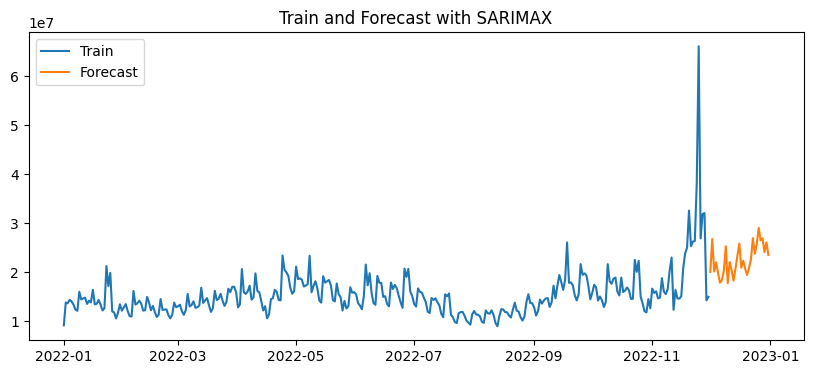

In [76]:
plot_future(y['2022':], predictions, "SARIMAX")